In [1]:
from tslearn.barycenters.dba import dtw_barycenter_averaging
from Server.http_interface import socketio, app
from Tracker.Tracker import TrackerControls
from Tracker.TrackerPacket import TrackerPacket
from Tracker.Motion import Motion
import json
import threading
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# LOAD MOTIONS
from settings import MOTIONS_FILE_PATH, MOTIONS_FILE_PATH_LOCK, MOTIONS_FOLDER
import json
import os
from tslearn.metrics import cdist_dtw

In [2]:

def moving_average(data, window_size=3):
    weights = np.repeat(1.0, window_size) / window_size
    smoothed_data = np.convolve(data, weights, 'valid')
    return smoothed_data


def interpolate(s, m=140):
    if len(s) < m:
        f = interp1d(np.linspace(0, 1, len(s)), s, kind='linear')
        interpolated_stream = f(np.linspace(0, 1, m))
    else:
        interpolated_stream = s[:m]
    return interpolated_stream.astype(dtype=np.dtype('>i2'))


def preprocess(s):
    s = interpolate(s)
    # s = moving_average(s)
    return s


In [3]:
with MOTIONS_FILE_PATH_LOCK:
    with open(MOTIONS_FILE_PATH, "r") as f:
        motions_header = json.load(f)


labeled_motions: dict = {

}

for motion_header in motions_header["stored_motions"]:
    new_motion = Motion.from_file(os.path.join(
        MOTIONS_FOLDER, motion_header["id"]))
    if new_motion is None:
        print("Failed to open motion")
        exit(0)

    labeled_motions[motion_header["label"]] = labeled_motions.get(motion_header["label"], [
        [], [], [], [], [], [],
    ])

    for shape in motion_header["shapes_acce"]:
        streams = new_motion.as_linear()

        for i, stream in enumerate(streams):
            cut_motion = stream[shape["start"]:shape["end"]]
            if len(cut_motion) == 0:
                continue
            labeled_motions[motion_header["label"]
                            ][i].append(preprocess(cut_motion))

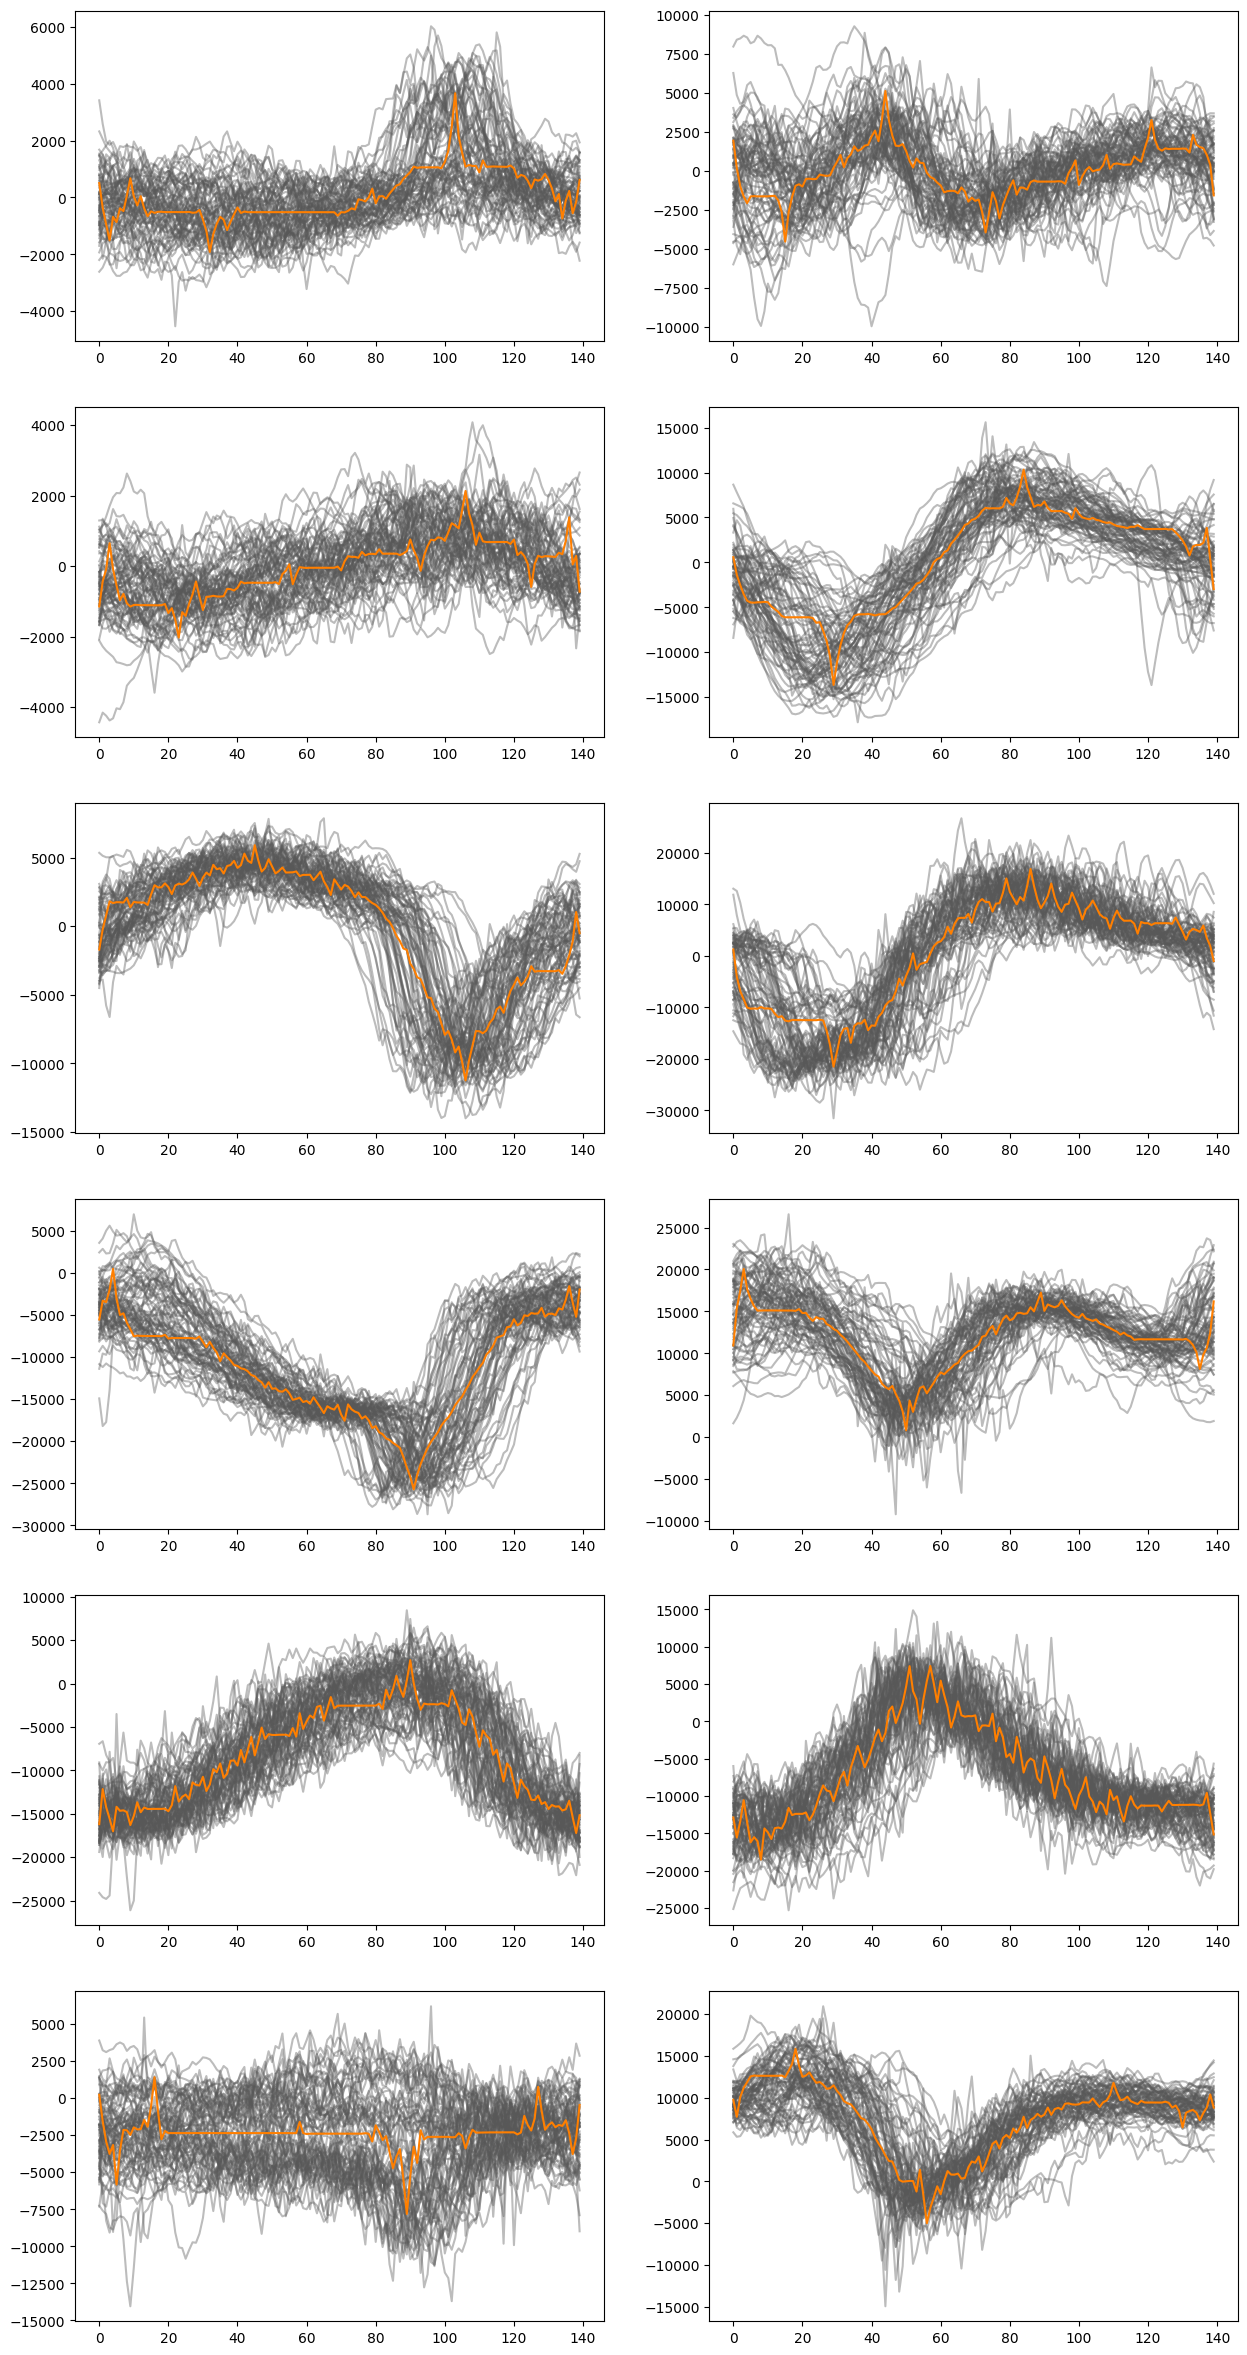

In [4]:
colors = sns.color_palette("Paired")

fig, axs = plt.subplots(6, 2)
fig.set_figheight(30)
fig.set_figwidth(15)
averages = [
    [],
    [],
    [],
    [],
    [],
    [],
]
for i, (key, val) in enumerate(labeled_motions.items()):

    for j, streams in enumerate(val):
        center = dtw_barycenter_averaging(streams).ravel()
        for s in streams:
            axs[j, i].plot(s, alpha=.4, color="#585858")
        axs[j, i].plot(center, label=f"Centroid", alpha=1,
                       color=colors[7], linestyle="-")

        averages[j].append(center)


# Show the plot
plt.savefig("OUT")
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt

sliding_window = [[], [], [], [], [], []]
sliding_window_size = 7
#fig, ax[0][0][0][0][0][0][0][0][0][0][0][0][0][0][0]s = plt.subplots(50, 2, figsize=(15, 90))  # Adjusted figsize here

count = 0
scores = [
    [
        [],
        [],
        [],
        [],
        [],
        [],
        
        ],
    [
        [],
        [],
        [],
        [],
        [],
        [],
        ],
]
for j,packet in enumerate( new_motion.packets):
    for i, stream in enumerate(packet.readings):
        sliding_window[i].append(stream)

    while len(sliding_window[0]) > sliding_window_size:
        [s.pop(0) for s in sliding_window]  # Fixed pop operation here

    if len(sliding_window[0]) != sliding_window_size:
        continue
    for i, s in enumerate(sliding_window):
        row = np.concatenate(s)
        res = cdist_dtw(row, averages[i])
        scores[0][i].append(res[0][0])
        scores[1][i].append(res[0][1])
    count += 1  
    
"""        
        if i == 3:
            axs[count, 0].plot(averages[i][0], label=f"{res[0][0]}", color=colors[7])  # Changed assignment to plotting
            axs[count, 1].plot(averages[i][1], label=f"{res[0][1]}", color=colors[7])  # Changed assignment to plotting
            axs[count, 0].plot(row,  color="#000000")  # Changed assignment to plotting
            axs[count, 1].plot(row,  color="#000000")  # Changed assignment to plotting
            
            axs[count, 0].legend()
            axs[count, 1].legend()

            count += 1  
    if count >= 50:
        break"""
    
plt.show()


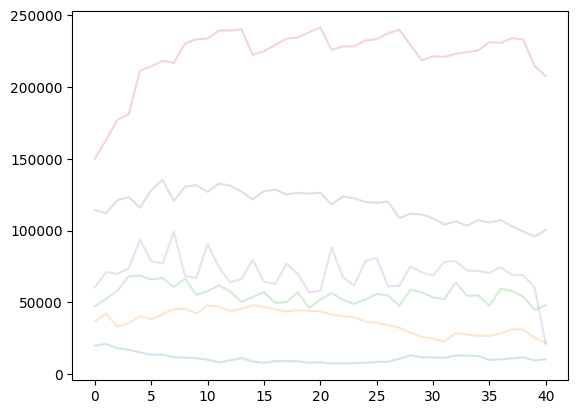

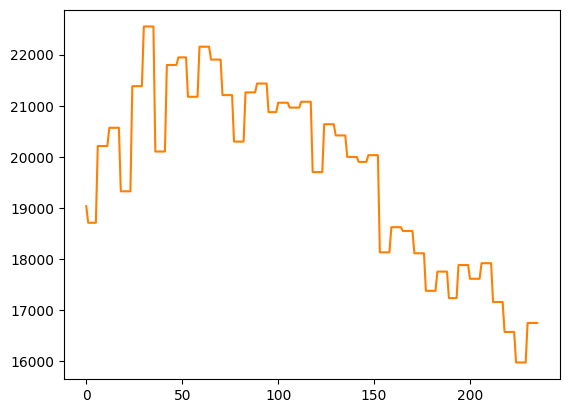

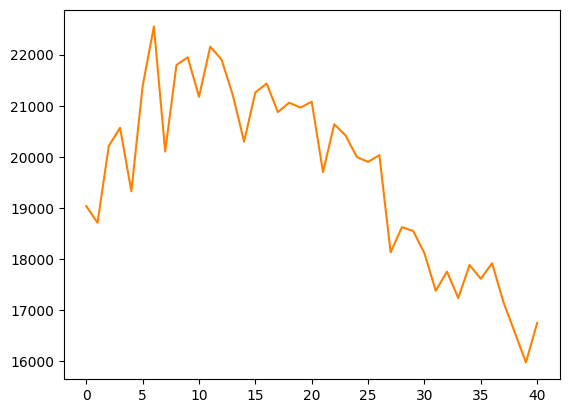

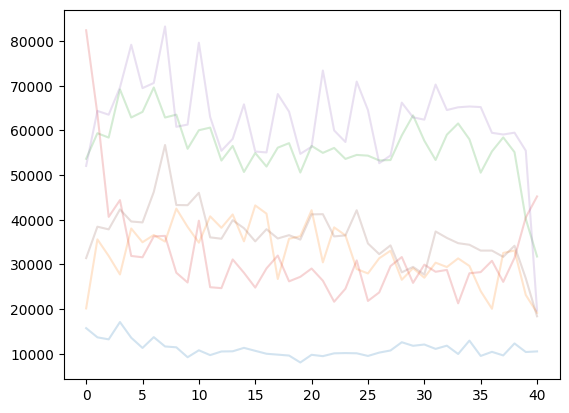

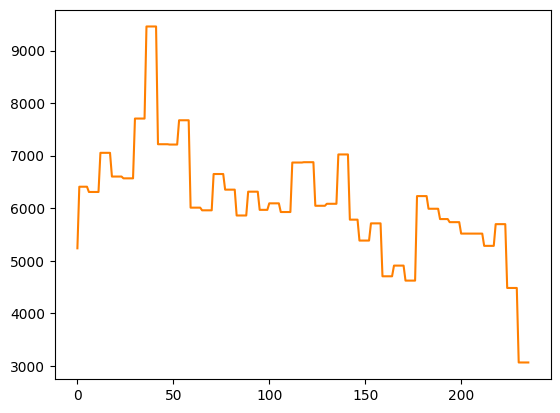

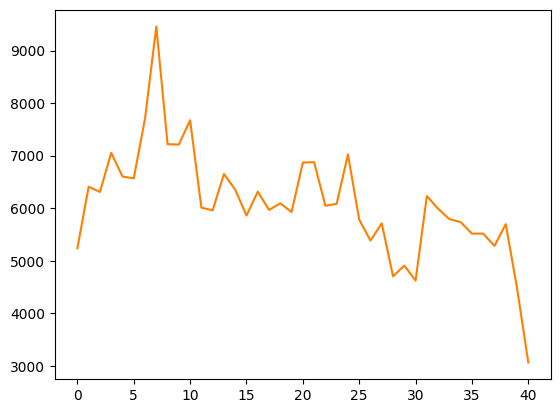

In [10]:
for s in scores[0]:
    plt.plot(s, alpha=.2)
plt.show()
scores_sums = [[],[]]
    
def interpolate2(data, size):
    if(size < len(data)):
        return
    
    repeated_vals = size /len( data)
    
    interpolated_data = []
    added = 0
    for val in data:
        interpolated_data.append(val)
        while( added > 1):
            interpolated_data.append(val)
            added -= 1
        
        added += repeated_vals
        
    return np.array( interpolated_data)


for i in range(len(scores[0][0])):
    curr_sum = 0
    for j in range(6):
        curr_sum =+ scores[0][j][i]
    scores_sums[0].append(curr_sum/6)
plt.plot(interpolate2(scores_sums[0],200), color=colors[7])
plt.show()
plt.plot(scores_sums[0], color=colors[7])
plt.show()


for s in scores[1]:
    plt.plot(s, alpha=.2)
plt.show()
    
for i in range(len(scores[1][0])):
    curr_sum = 0
    for j in range(6):
        curr_sum =+ scores[1][j][i]
    scores_sums[1].append(curr_sum/6)
    
    
plt.plot(interpolate2(scores_sums[1],200), color=colors[7])
plt.show()

plt.plot(scores_sums[1], color=colors[7])

plt.show()


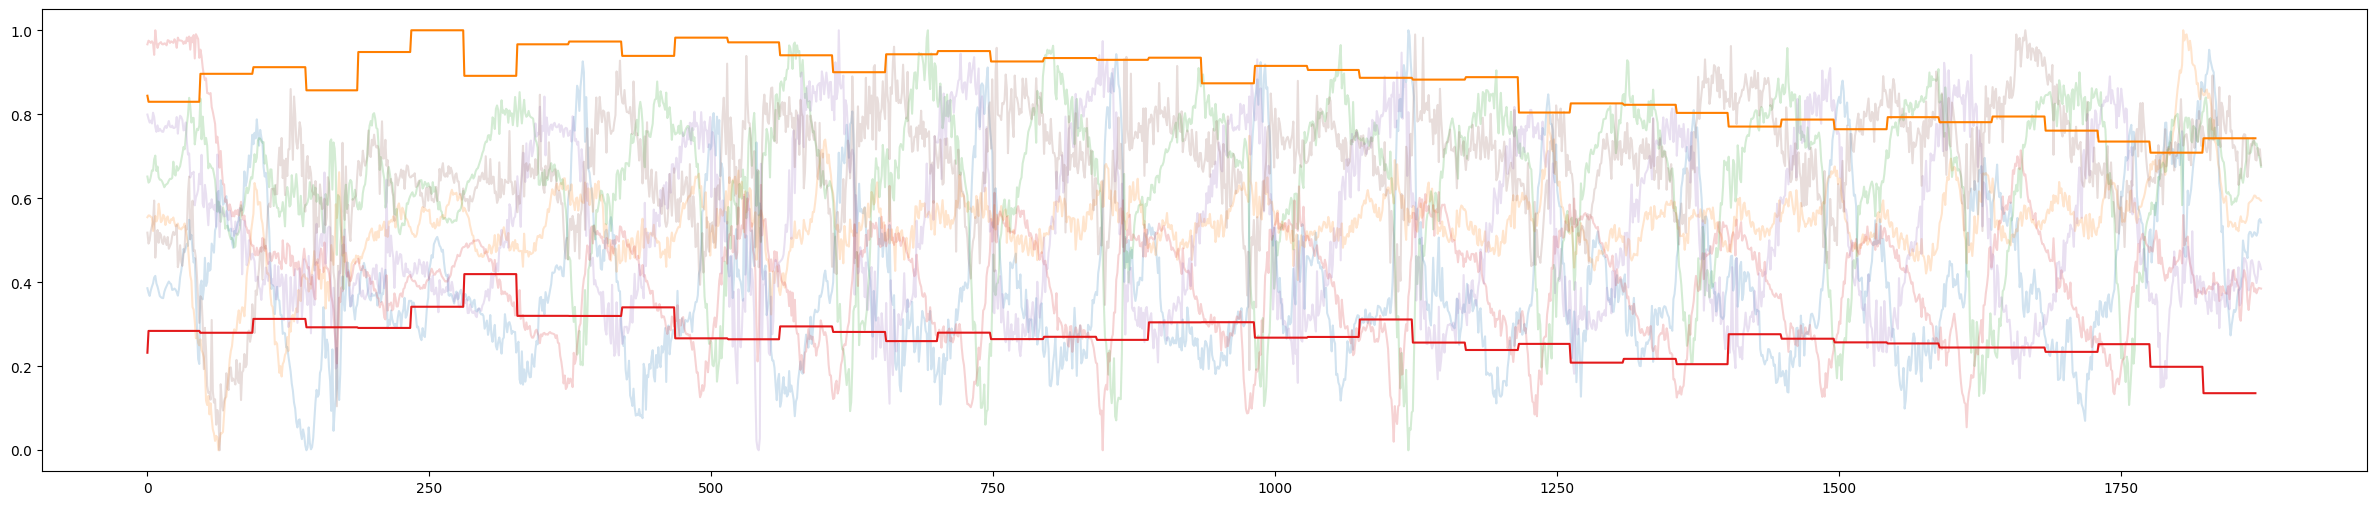

In [8]:
new_motion = Motion.from_file(os.path.join(MOTIONS_FOLDER, motions_header["stored_motions"][0]["id"]))
from sklearn import preprocessing as pre

# Create a figure
plt.figure(figsize=(30, 6))  

def normali(data,min_val,max_val):
    if min_val > 0:
        min_val = 0
    
    res = []
    for val in data:
        res.append((val - int(min_val)) / (int(max_val) - min_val))
            
    return res

# Plot motion data
for s in new_motion.as_linear():
    normalized_s = normali(s,min(s),max(s))
    plt.plot(normalized_s, alpha=0.2)


# Interpolate and plot scores_sums arrays
scores_interpolated1 = interpolate2(scores_sums[0], len(s))
scores_interpolated2 = interpolate2(scores_sums[1], len(s))
val_max = 0
if max(scores_interpolated1) > max(scores_interpolated2):
    val_max =  max(scores_interpolated1)
else :
    val_max =  max(scores_interpolated2)
val_min = 0
if min(scores_interpolated1) < min(scores_interpolated2):
    val_min =  min(scores_interpolated1)
else :
    val_min =  min(scores_interpolated2)
# Normalize interpolated arrays before plotting
normalized_scores_interpolated1 =normali(scores_interpolated1,val_min,val_max)

normalized_scores_interpolated2 =normali(scores_interpolated2,val_min,val_max)

plt.plot(normalized_scores_interpolated1, color=colors[7])
plt.plot(normalized_scores_interpolated2, color=colors[5])

plt.show()

In [1]:
from Tracker.Tracker import TrackerControls
import time

recording_path = "./TEST_RECORDING"

TC = TrackerControls("192.168.86.29", "192.168.86.247", 3002,file_template=recording_path)

TC.receiver_init()
print("RECEIVING")

while( not TC.is_connected()):
    time.sleep(1)
    print("trying to connect")
print("Connected, filming in 5s")
time.sleep(5)

TC.controls("switch --save-file")


time.sleep(100)

TC.controls("switch")

TC.receiver_stop()

RECEIVING
{'quaternion_row_len': 4, 'accelerometer_row_len': 3, 'gyro_row_len': 3, 'buffer_max_size': 2048, 'hz': 50, 'readings_per_packet': 25, 'stream_port': 3000, 'session_id': 'q6jovbhlB5J93ufJ0'}
trying to connect
Connected, filming in 5s


In [ ]:
import json
new_motion=TC.get_motion()

with open("./TEST3", "wb") as fd:
    tracker_settings_str = json.dumps(new_motion._tracker_settings)
    tracker_binary = tracker_settings_str.encode(
        encoding="ascii", errors="ignore")
    fd.write(tracker_binary)
    fd.write(b'\x00')

    for packet in new_motion.packets:
        packet = bytes(packet.raw_data)
        fd.write(packet)
                        
                    
    fd.close()

In [2]:
%matplotlib notebook

In [2]:
from Tracker.Motion import Motion 
import matplotlib.pyplot as plt

recorded_motion = Motion.from_file("/home/guiso/code/gymTracker/python/src/test2")



In [1]:
from MotionRecognition.tools import load_centroids

import numpy as np

labeled_centroids = [(label,centroid) for label,centroid in load_centroids().items()]

centroids = [centroid for _,centroid in labeled_centroids]

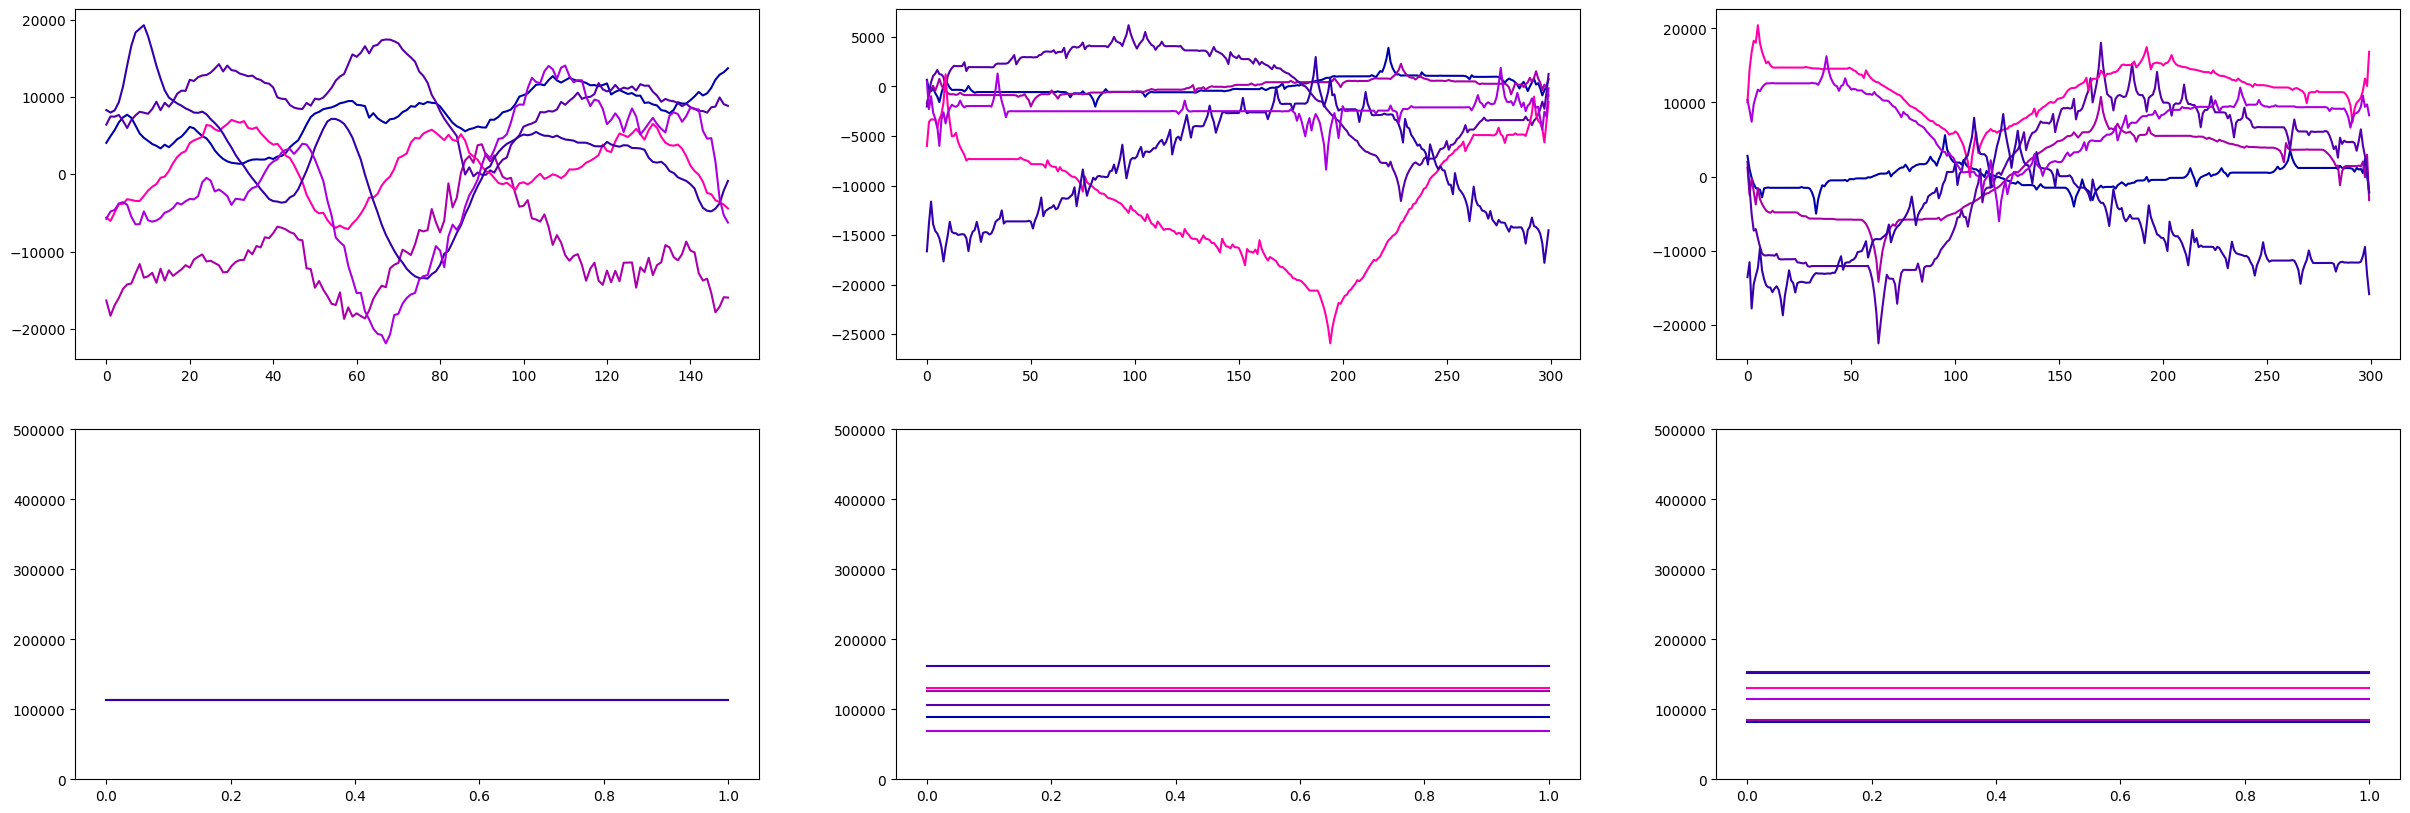

In [31]:
from MotionRecognition.MotionRecognition import MotionRecognition

mr = MotionRecognition(centroids=centroids)
similar_colors_hex = [
    "#0000AA",  # Orange
    "#AA00AA",  # Darker orange
    "#5500AA",  # Dark orange
    "#FF00AA",  # Tomato
    "#3300AA",  # Coral
    "#AA00DD"   # Light salmon
]

res = []
packet_count = 0
for packet in recorded_motion.packets:
    for i in range(0,packet.nb_readings,5):
        
        mr.slide_window(packet.readings[:,i:i+5])
        res.append(mr.cmpr())
        if(packet_count == 950):
            fig, axs = plt.subplots(2, 3)
            fig.set_figheight(10)
            fig.set_figwidth(30)
            
            for stream,color in zip(mr.sliding_windows,similar_colors_hex):
                axs[0,0].plot(stream, color=color)

            for stream,color in zip(mr.centroids[0],similar_colors_hex):
                axs[0,1].plot(stream, color=color)
            
            for stream,color in zip(mr.centroids[1],similar_colors_hex):
                axs[0,2].plot(stream, color=color)    
            avg = 0    
            for stream,color in zip(res[-1],similar_colors_hex):
                axs[1,1].plot([stream[0],stream[0]], color=color)
                axs[1, 1].set_ylim(0, 500_000)
                avg += stream[0]
                
            axs[1,0].plot([avg/6,avg/6], color="000000")
            
            avg = 0    
            for stream,color in zip(res[-1],similar_colors_hex):
                axs[1,2].plot([stream[1],stream[1]], color=color)
                axs[1, 2].set_ylim(0, 500_000)
                avg += stream[0]
                
            axs[1,0].plot([avg/6,avg/6], color="#3300AA")
            axs[1, 0].set_ylim(0, 500_000)


                        
            plt.show()
        
        packet_count += 5

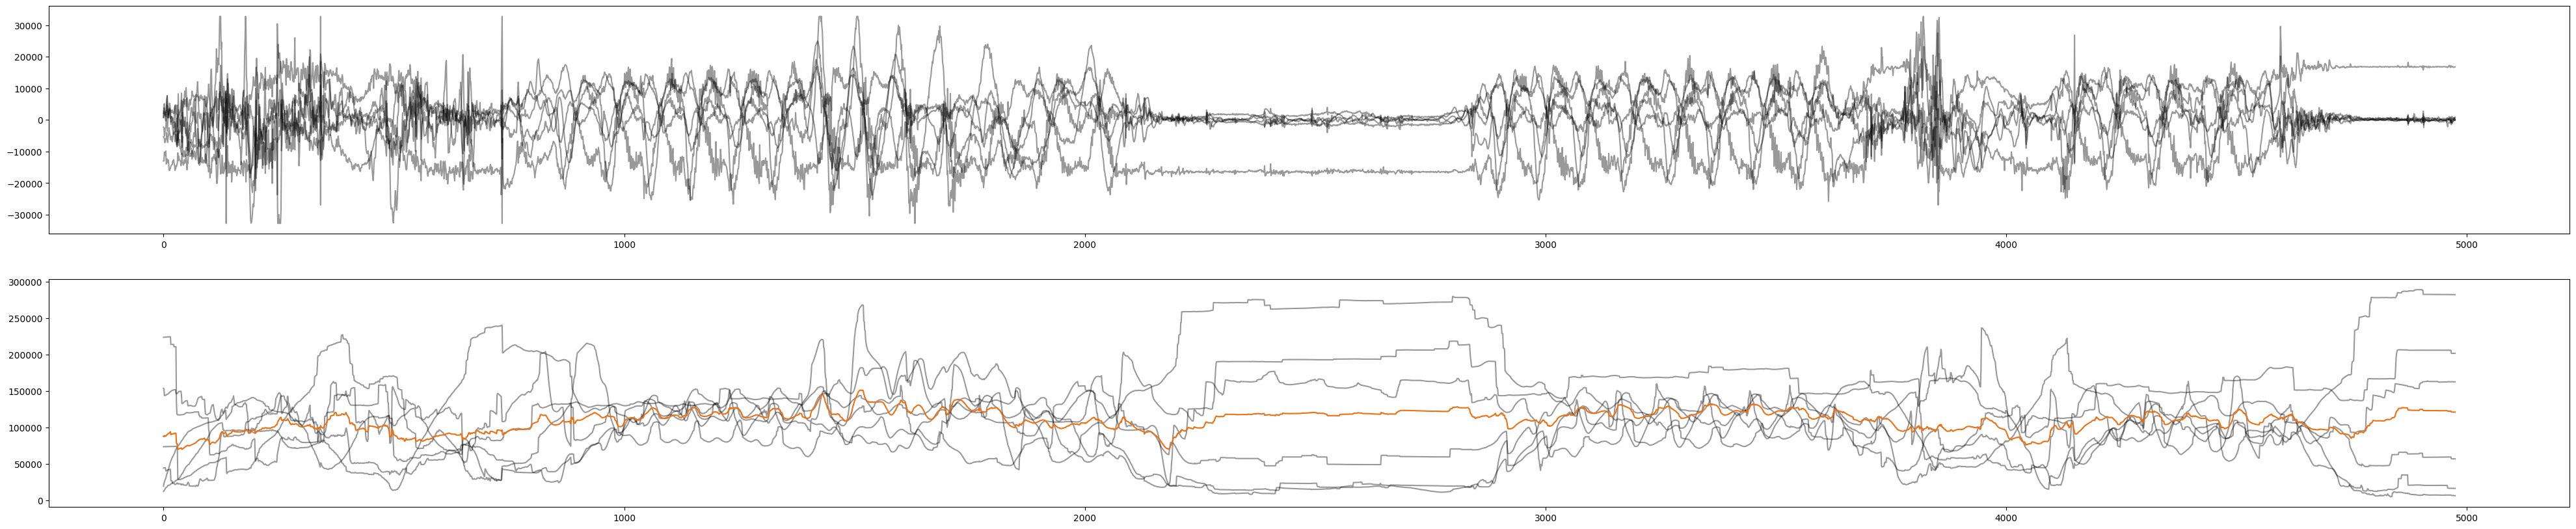

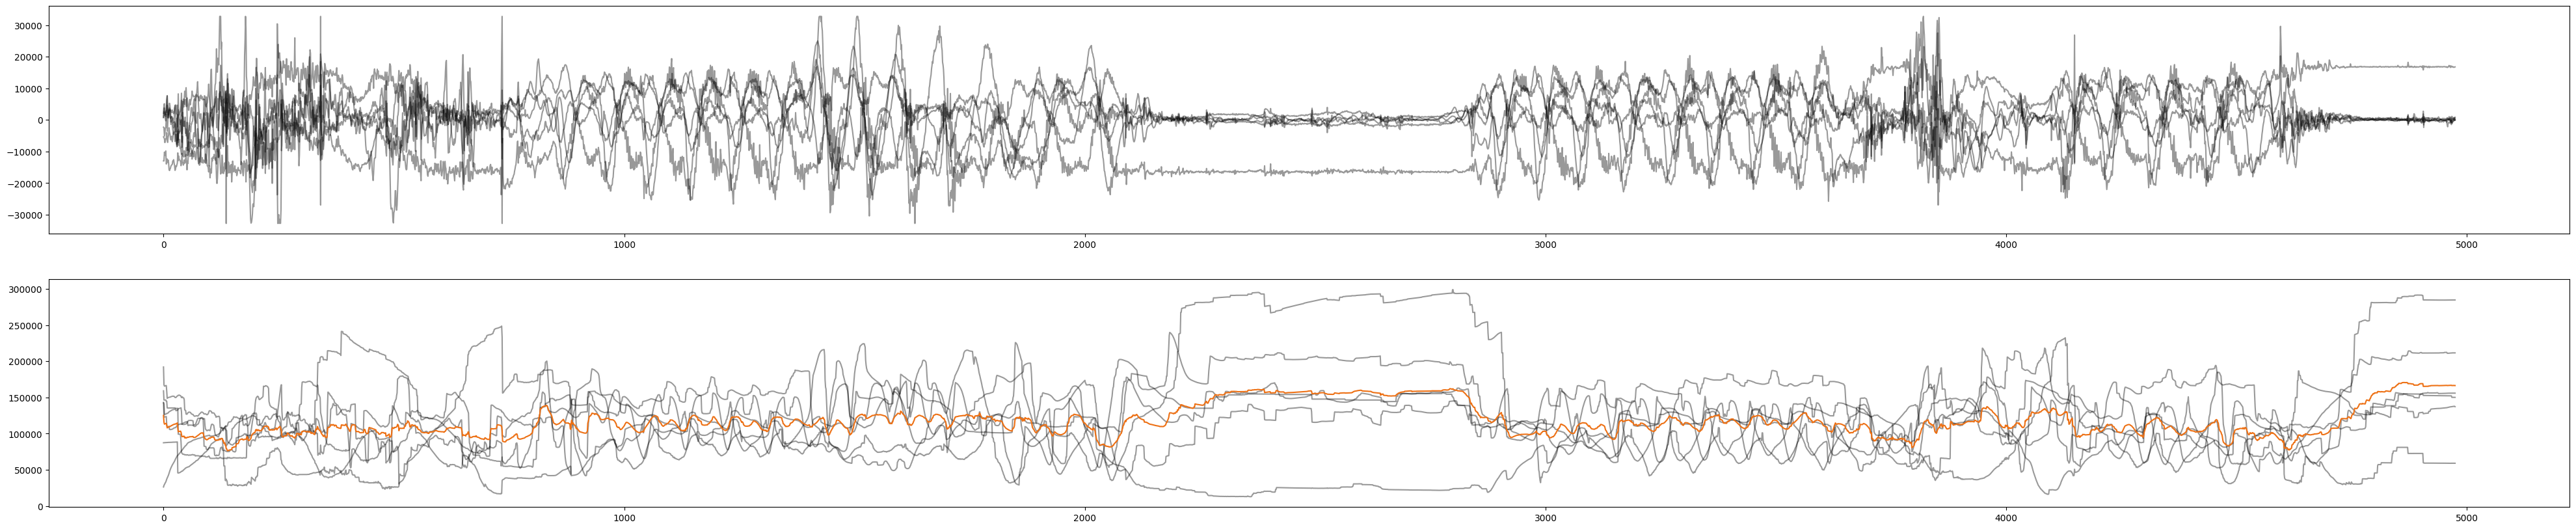

In [10]:
from MotionRecognition.tools import interpolate
linear_results = [[[] for _ in range(6)] for _ in range(len(centroids))]
sums = [[] for i in range(len(centroids))]

for streams in res:
    for i, stream in enumerate(streams):
        for j, centroid_result in enumerate(stream):
            linear_results[j][i].append(centroid_result)

    for i in range(len(centroids)):
        curr_sum = 0
        for stream in streams:
            curr_sum += stream[i]

        sums[i].append(curr_sum / 6)

streams = recorded_motion.as_linear()


for i,sum_ in enumerate( sums): 
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(50)
    for stream in streams:
        axs[0].plot(stream, color="000000", alpha=.4)


    for linear_result in linear_results[i]:
        axs[1].plot(linear_result, color="000000", alpha=.4)
        
    axs[1].plot(interpolate(sum_,m=len(linear_result)), color="#ED7014")
    plt.show()




In [5]:
from MotionRecognition.tools import load_data

data = load_data()
len(list(data.values())[0][0])

71